/home/admin_user/.pyenv/versions/3.10.8/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device: cuda
test dataset: (65536, 2) 

sequential_model(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=20, bias=True)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Linear(in_features=20, out_features=20, bias=True)
    (6): Linear(in_features=20, out_features=20, bias=True)
    (7): Linear(in_features=20, out_features=20, bias=True)
    (8): Linear(in_features=20, out_features=1, bias=True)
  )
)


<AxesSubplot: title={'center': '$u(x)$'}, xlabel='$y$', ylabel='$x$'>

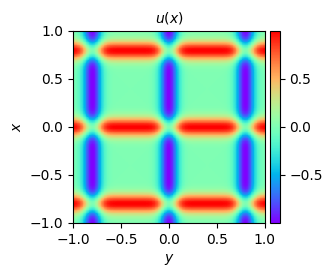

In [1]:
import numpy as np
import torch

from visualization import *
from main import *
from used_attacks import regression_PGD

''' Settings and seeds '''

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("device:", device)

if device == 'cuda': 
    print(torch.cuda.get_device_name()) 
    
''' test dataset '''
def poisson2d_gt(x,y):
    return np.exp(-np.square(10*x-8)) - np.exp(-np.square(10*y-8)) +\
        np.exp(-np.square(10*x+8)) - np.exp(-np.square(10*y+8)) +\
        np.exp(-np.square(10*x)) - np.exp(-np.square(10*y))

x = np.linspace(-1, 1, 256)
y = np.linspace(-1, 1, 256)
X, Y = np.meshgrid(x,y)
U_gt = poisson2d_gt(X, Y)

x_test = np.hstack((X.flatten()[:,None], Y.flatten()[:,None]))
u_test = U_gt.flatten()[:,None]
print("test dataset:", x_test.shape, '\n')

''' model '''

layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers
PINN = sequential_model(layers, device)
PINN.to(device)
print(PINN)
plot_u(U_gt, x, y, title="$u(x)$")

In [2]:
def generate_attack_samples(model, device, x_train, N0, n_samples=1000, \
    lb=[-1,-1], ub=[1,1], steps=20, eps=1e-1, eta=2e-2, m=1):
    
    attack = regression_PGD(model, lb=lb, ub=ub, steps=steps, eps=eps, eta=eta)
    x_adv = attack.attack(x_train).cpu().detach().numpy()
    
    if x_adv.shape[0] > N0 + (m+1)*n_samples:
        x_adv = np.vstack([x_adv[:N0,:] ,x_adv[-(m+1)*n_samples:,:]])

    f_adv_pred = np.abs(model.function(x_adv).squeeze().cpu().detach().numpy())
    index = np.argsort(f_adv_pred)[::-1][:n_samples]
    x_adv = x_adv[index,:]
    f_adv_pred = f_adv_pred[index]
    
    plot_samples(x_adv, f_adv_pred)
    
    return x_adv


def retrain(model, x_train, x_adv, x_boundary, u_boundary, x_test, u_test, U_gt, epoch=1e5):
    
    f_test_pred = np.abs(PINN.function(x_test).squeeze().cpu().detach().numpy())
    plot_u(f_test_pred.reshape(X.shape), x, y, log=True, title="test $r(x;theta)$")

    model.iter = 0
    optimizer = torch.optim.Adam(PINN.parameters(), lr=0.0001)
    model.train_model_adam(optimizer, x_boundary, u_boundary, np.vstack([x_train, x_adv]), epoch)
                           
    rmse, u_pred = model.test(x_test, u_test)
    print('Test RMSE: %.5f'  % (rmse))
                           
    plot_u_x(u_pred.reshape(X.shape), U_gt, x, y)
    plot_u(np.abs(u_pred.reshape(X.shape)-U_gt), x, y, log=True, title="$|u(x;theta)-u(x)|$")

1000 tensor(7877.0942, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(7593.6812, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(7118.2773, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(6856.1641, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(6695.9028, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(6526.9185, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(6438.7388, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(6370.4087, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(6318.7349, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(6261.4917, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(6216.8726, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(6158.7783, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(6056.2378, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(5864.5493, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(5464.5225, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(5294.3472, device='cu

128000 tensor(446.6385, device='cuda:0', grad_fn=<AddBackward0>)
129000 tensor(431.5233, device='cuda:0', grad_fn=<AddBackward0>)
130000 tensor(426.4207, device='cuda:0', grad_fn=<AddBackward0>)
131000 tensor(421.5917, device='cuda:0', grad_fn=<AddBackward0>)
132000 tensor(416.9700, device='cuda:0', grad_fn=<AddBackward0>)
133000 tensor(412.7471, device='cuda:0', grad_fn=<AddBackward0>)
134000 tensor(408.1357, device='cuda:0', grad_fn=<AddBackward0>)
135000 tensor(404.0151, device='cuda:0', grad_fn=<AddBackward0>)
136000 tensor(399.8661, device='cuda:0', grad_fn=<AddBackward0>)
137000 tensor(396.0578, device='cuda:0', grad_fn=<AddBackward0>)
138000 tensor(391.8977, device='cuda:0', grad_fn=<AddBackward0>)
139000 tensor(389.0161, device='cuda:0', grad_fn=<AddBackward0>)
140000 tensor(385.0156, device='cuda:0', grad_fn=<AddBackward0>)
141000 tensor(380.7960, device='cuda:0', grad_fn=<AddBackward0>)
142000 tensor(376.1662, device='cuda:0', grad_fn=<AddBackward0>)
143000 tensor(397.7416, d

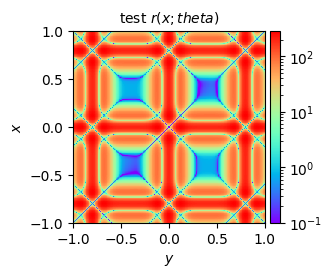

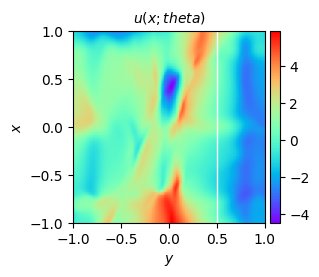

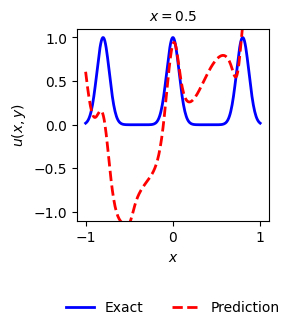

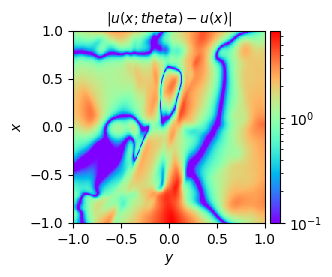

In [3]:
''' k=0 '''
N0 = 500
x_train, x_boundary, u_boundary = training_data_latin_hypercube(X, Y, U_gt, N_inner=N0)
retrain(PINN, x_train, np.array([]).reshape((0,2)), x_boundary, u_boundary, x_test, u_test, U_gt, epoch=2e5)

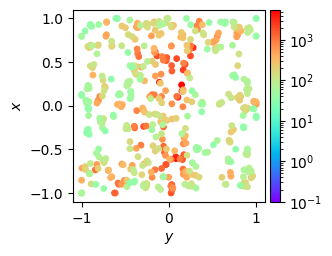

1000 tensor(8545.7051, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(4794.1650, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(3373.1570, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(2593.9053, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(1975.2836, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(1562.5409, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(1281.0714, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(1079.5201, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(943.9907, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(834.3475, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(730.7823, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(648.6644, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(590.0203, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(543.3262, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(515.7402, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(471.9200, device='cuda:0', g

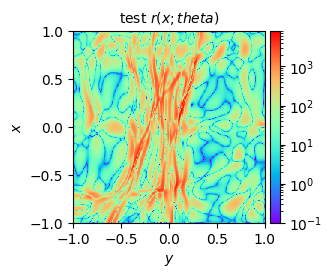

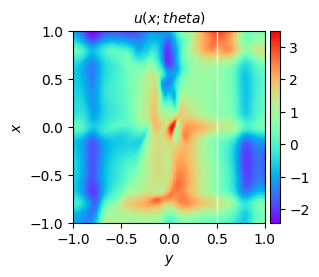

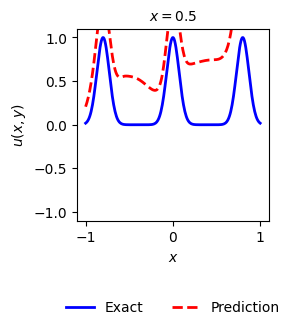

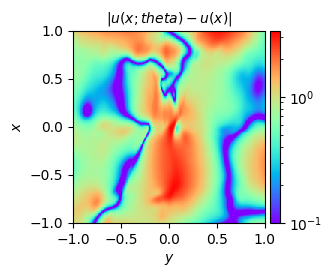

In [4]:
''' k=1 '''
x_adv = generate_attack_samples(PINN, device, x_train, N0, n_samples=500)
retrain(PINN, x_train, x_adv, x_boundary, u_boundary, x_test, u_test, U_gt, epoch=5e4)

k= 2


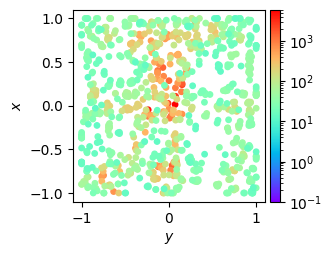

1000 tensor(3608.2825, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(2358.4395, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(1781.1909, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(1398.1578, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(1076.6134, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(787.3616, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(609.7800, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(503.1966, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(433.4331, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(382.9305, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(343.4625, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(316.1004, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(285.1987, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(263.3441, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(244.6063, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(231.0497, device='cuda:0', grad

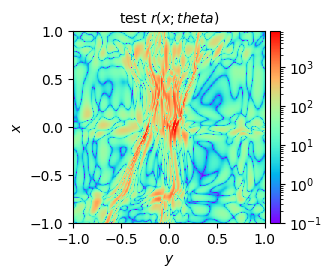

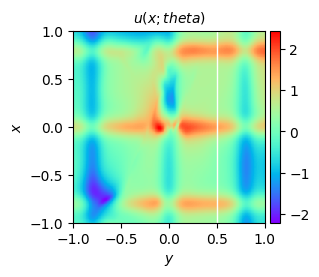

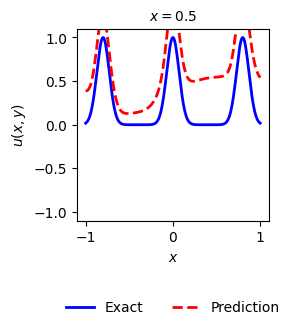

k= 3


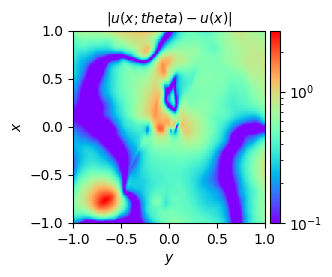

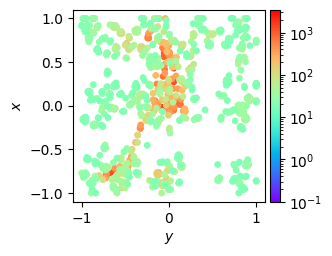

1000 tensor(1169.8691, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(663.2067, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(468.1983, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(349.6842, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(268.2410, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(209.0475, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(164.4149, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(131.8583, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(108.6558, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(91.4057, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(78.1840, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(67.8402, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(59.7178, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(53.3687, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(47.6638, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(43.5837, device='cuda:0', grad_fn=<AddBac

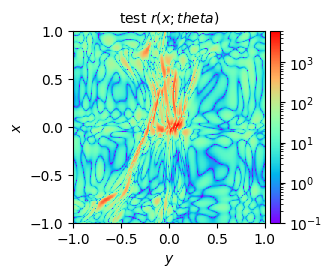

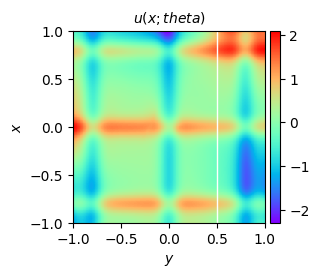

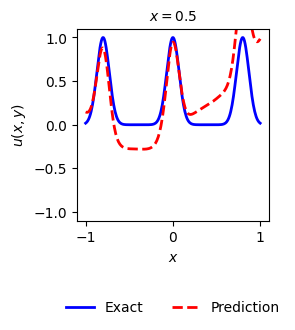

k= 4


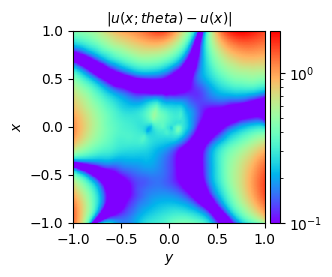

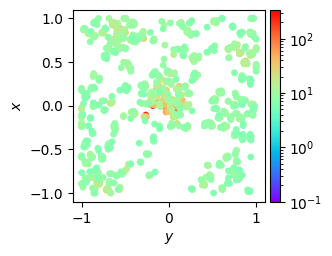

1000 tensor(30.5815, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(24.4642, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(21.5125, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(19.4252, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(17.8949, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(16.4990, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(15.7084, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(14.3705, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(13.5534, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(12.8675, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(12.3346, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(11.6150, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(11.0631, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(10.6017, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(10.2007, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(9.7878, device='cuda:0', grad_fn=<AddBackward0>)
17

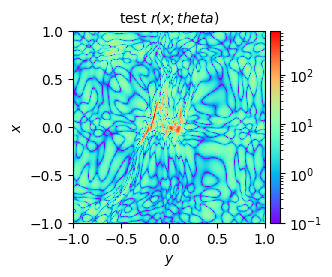

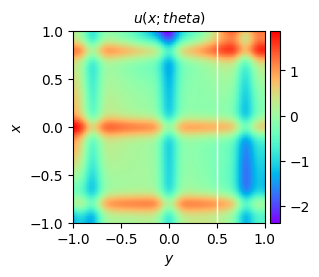

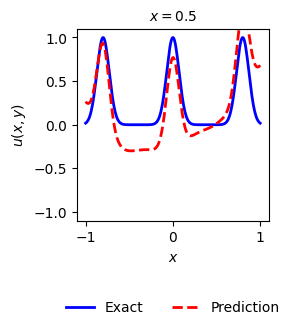

k= 5


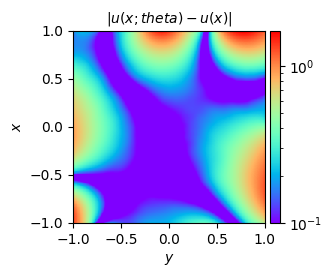

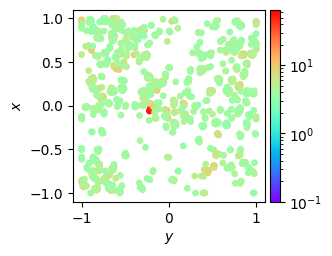

1000 tensor(7.7639, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(7.1383, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(6.8664, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(6.6356, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(6.4416, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(6.2390, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(6.0639, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(5.9396, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(5.7625, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(5.8233, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(5.4928, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(5.3637, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(5.5134, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(5.1436, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(5.0625, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(5.0794, device='cuda:0', grad_fn=<AddBackward0>)
17000 tensor(4.80

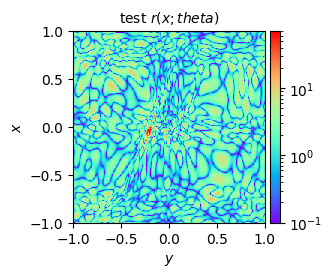

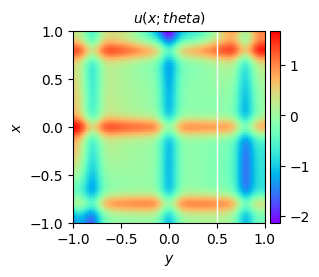

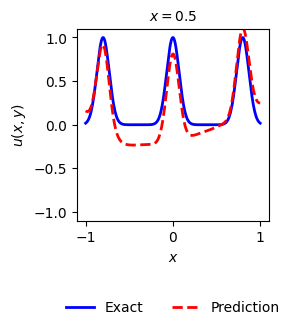

k= 6


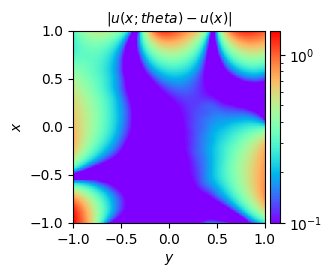

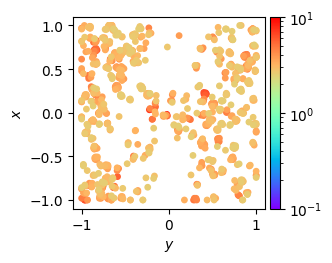

1000 tensor(3.9162, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(3.7974, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(3.7228, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(3.6484, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(3.5787, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(3.5218, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(3.4884, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(3.4412, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(3.3602, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(3.3773, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(3.2725, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(3.2459, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(3.1802, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(3.1387, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(3.1272, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(3.1302, device='cuda:0', grad_fn=<AddBackward0>)
17000 tensor(3.12

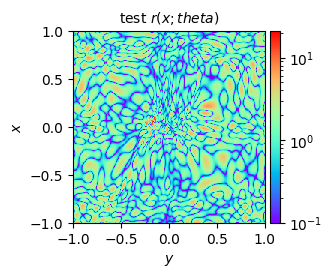

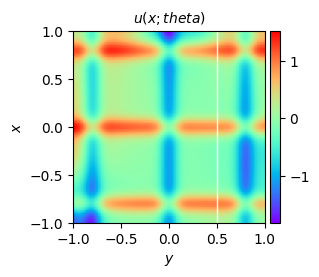

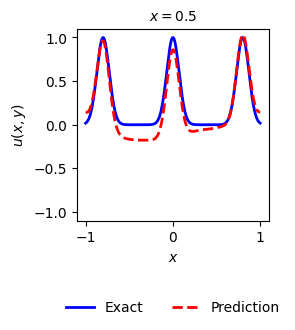

k= 7


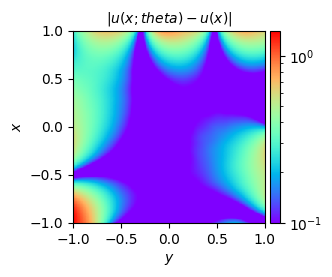

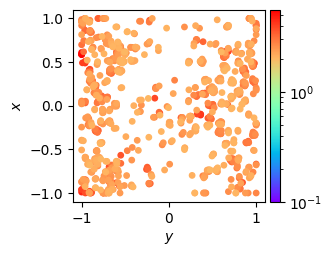

1000 tensor(2.6468, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(3.1346, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(2.5846, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(2.5293, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(2.5316, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(2.4685, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(2.4770, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(2.4177, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(2.4001, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(2.3689, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(2.3429, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(2.3189, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(2.2959, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(2.2749, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(2.3305, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(2.2405, device='cuda:0', grad_fn=<AddBackward0>)
17000 tensor(2.21

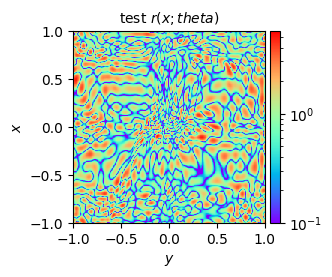

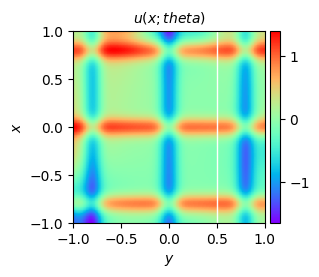

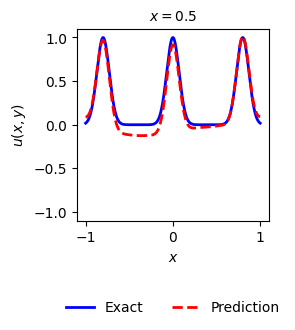

k= 8


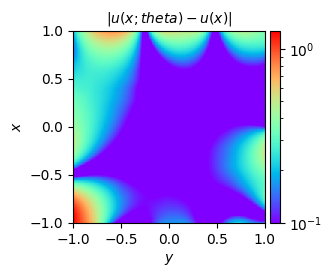

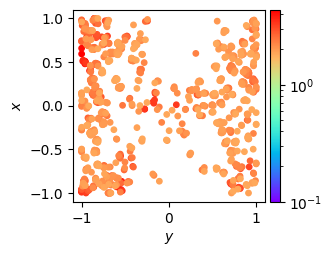

1000 tensor(1.9752, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(1.9646, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(1.9224, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(2.0954, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(1.9331, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(2.0541, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(1.8799, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(1.8755, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(1.8298, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(1.8167, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(2.1453, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(2.3587, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(1.7858, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(1.8709, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(1.7598, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(1.8642, device='cuda:0', grad_fn=<AddBackward0>)
17000 tensor(1.72

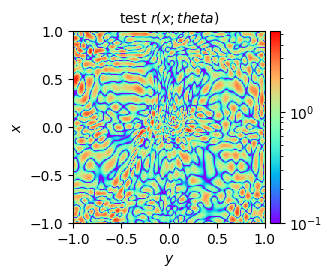

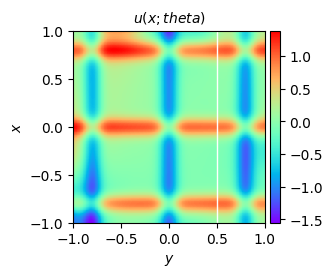

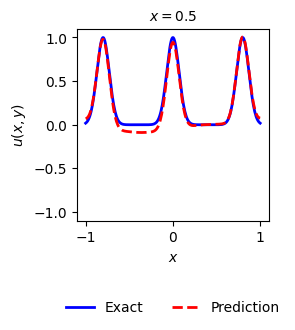

k= 9


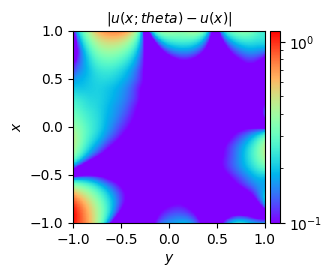

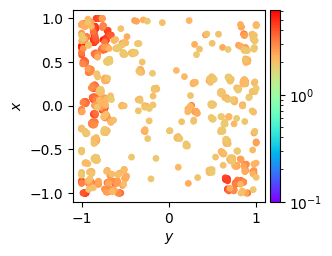

1000 tensor(1.5956, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(1.7602, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(1.6433, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(1.5528, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(1.6814, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(1.7653, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(1.5216, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(1.5125, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(1.5023, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(1.4957, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(1.5416, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(1.4805, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(1.4670, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(1.4586, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(1.5176, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(1.4666, device='cuda:0', grad_fn=<AddBackward0>)
17000 tensor(1.44

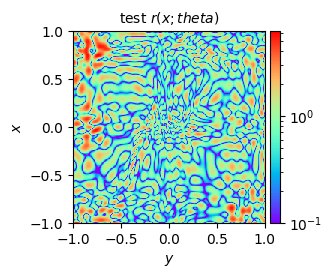

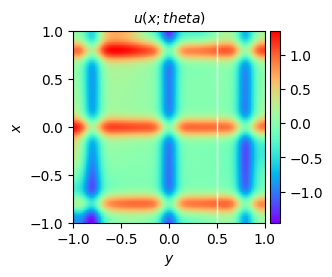

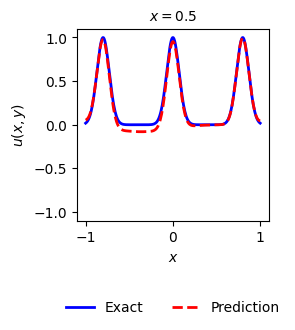

k= 10


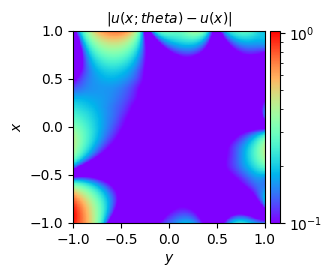

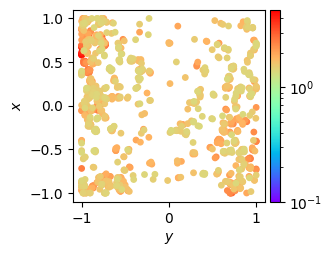

1000 tensor(1.4022, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(1.3924, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(1.4480, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(1.3761, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(2.1526, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(1.3671, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(1.4919, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(1.3473, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(1.4019, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(1.3350, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(1.3288, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(1.5033, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(1.3143, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(1.7926, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(2.4329, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(1.2969, device='cuda:0', grad_fn=<AddBackward0>)
17000 tensor(1.29

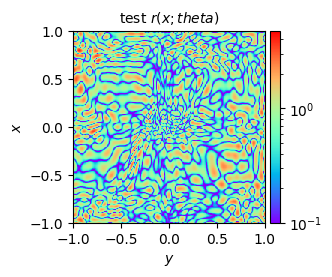

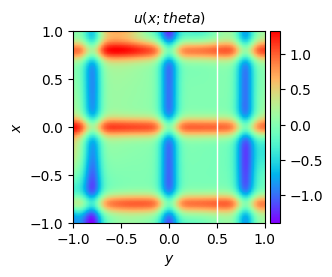

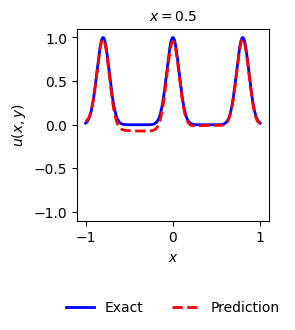

k= 11


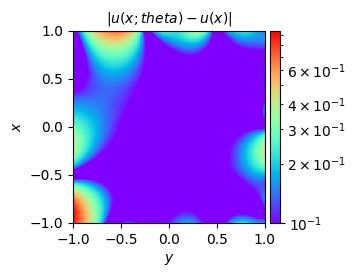

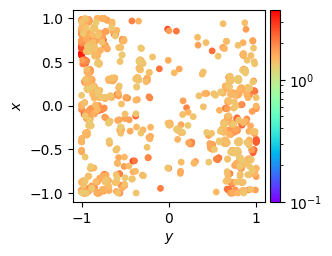

1000 tensor(1.2695, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(1.2622, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(1.2554, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(1.4702, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(1.2609, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(1.2368, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(1.2384, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(1.2684, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(1.2211, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(1.4121, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(1.2088, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(1.2028, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(1.2266, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(1.1982, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(1.5657, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(1.2090, device='cuda:0', grad_fn=<AddBackward0>)
17000 tensor(1.18

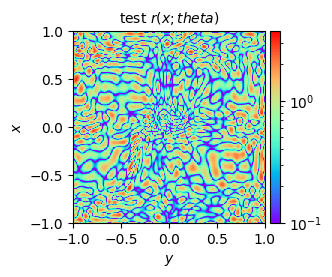

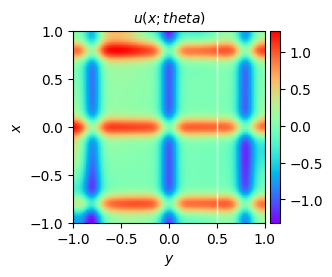

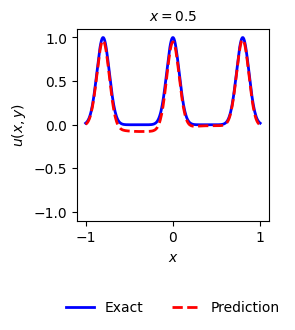

k= 12


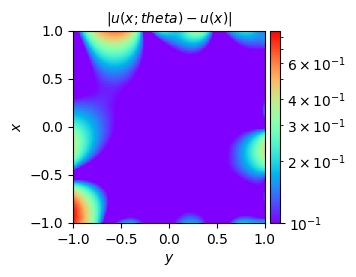

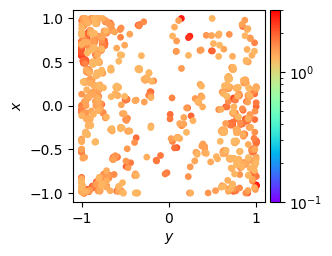

1000 tensor(1.1507, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(1.1446, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(1.1389, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(1.1345, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(1.1454, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(1.5280, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(1.1239, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(1.1352, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(1.1077, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(1.1059, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(1.8036, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(1.0943, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(2.5169, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(1.4537, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(1.3579, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(1.1355, device='cuda:0', grad_fn=<AddBackward0>)
17000 tensor(1.07

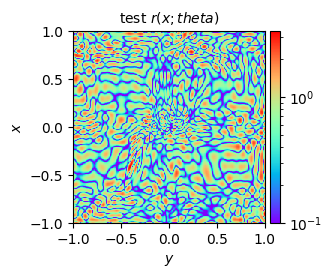

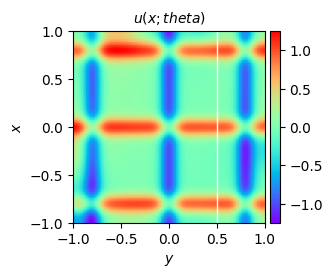

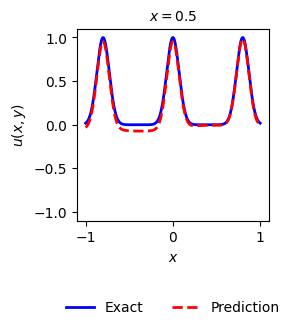

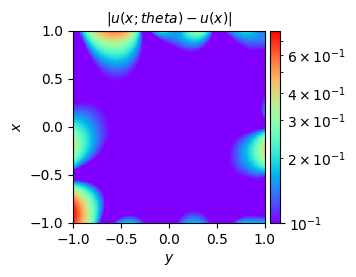

In [5]:
''' k=2:12 '''
for i in range(2,13):
    print("k=", i)
    x_train = np.vstack([x_train, x_adv])
    x_adv = generate_attack_samples(PINN, device, x_train, N0, n_samples=1000)
    retrain(PINN, x_train, x_adv, x_boundary, u_boundary, x_test, u_test, U_gt, epoch=5e4)